### This CNN uses three conv-pool blocks, with doubling number of filters used per block. Two dense layers at the end.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
import os
root_logdir = os.path.join(os.curdir, "conv_pool_batch_large_kernel_multi_conv_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [2]:
batch_size = 32
target_size = (512,384)
n_training_images = 2051

train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  rotation_range=10,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  validation_split=0.15)

test_datagen = ImageDataGenerator(rescale=1./255, 
                                  validation_split=0.15)


train_generator = train_datagen.flow_from_directory('../data/images/train',
                                                    color_mode='rgb',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    subset='training')

validation_generator = test_datagen.flow_from_directory('../data/images/train',
                                                       color_mode='rgb',
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='categorical',
                                                       subset='validation')

holdout_generator = test_datagen.flow_from_directory('../data/images/holdout',
                                                       color_mode='rgb',
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='categorical')

labels = (train_generator.class_indices)
labels = dict((v, k) for k,v in labels.items())
labels


Found 1937 images belonging to 6 classes.
Found 339 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [6]:
model=Sequential()

model.add(Conv2D(32, (7,7), strides=4, padding='same', input_shape=(target_size[0], target_size[1], 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3, strides=2))

model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=n_training_images*10//batch_size,
#     decay_rate=0.9)


opt = keras.optimizers.Adam(learning_rate=.001)

model.compile(loss='categorical_crossentropy',
             optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 96, 32)       4736      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 96, 32)       128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 47, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 63, 47, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 23, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 31, 23, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 31, 23, 128)      

In [7]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('conv_pool_batch_large_kernel_multi_conv.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())


history = model.fit(
    train_generator,
    validation_data = validation_generator, 
    verbose=1,
    epochs = 1000,
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/1000
61/61 [==============================] - 153s 2s/step - loss: 1.8015 - accuracy: 0.2807 - val_loss: 1.8002 - val_accuracy: 0.1593
Epoch 2/1000
61/61 [==============================] - 148s 2s/step - loss: 1.4117 - accuracy: 0.4508 - val_loss: 1.8181 - val_accuracy: 0.1976
Epoch 3/1000
61/61 [==============================] - 150s 2s/step - loss: 1.3478 - accuracy: 0.4950 - val_loss: 1.7755 - val_accuracy: 0.2773
Epoch 4/1000
61/61 [==============================] - 148s 2s/step - loss: 1.2494 - accuracy: 0.5142 - val_loss: 1.7375 - val_accuracy: 0.3215
Epoch 5/1000
61/61 [==============================] - 149s 2s/step - loss: 1.2552 - accuracy: 0.5364 - val_loss: 2.4038 - val_accuracy: 0.2625
Epoch 6/1000
61/61 [==============================] - 149s 2s/step - loss: 1.1405 - accuracy: 0.5828 - val_loss: 1.4617 - val_accuracy: 0.4513
Epoch 7/1000
61/61 [==============================] - 153s 2s/step - loss: 1.0772 - accuracy: 0.5833 - val_loss: 1.5391 - val_accuracy: 0.4130

In [8]:
score = model.evaluate(holdout_generator
                       , verbose=0)
print('Holdout accuracy:', score[1])

Holdout accuracy: 0.8167330622673035


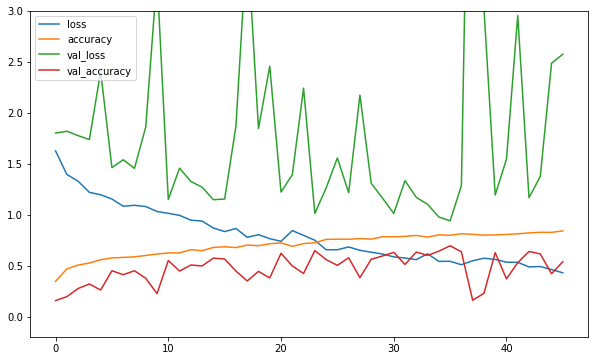

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
[plt.plot(history.history[i], label=i) for i in history.history.keys()]
plt.ylim(top=3)
plt.legend();

In [10]:
max(history.history['val_accuracy'])

0.6961652040481567